# Homework 10

* **Build the best model on the kaggle [Housing Data](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) that you can !**

* **Use only Ridge or lasso or elastic net.**

* **Upload a screenshot of your leaderboard ranking**

**import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.metrics import make_scorer
from sklearn import set_config; set_config(display='diagram')

In [2]:
df_train = pd.read_csv('../data/kaggle/HousePrices/train.csv')

In [3]:
X = df_train.drop(columns=['SalePrice','Id'])
y = df_train.SalePrice
X.shape

(1460, 79)

## Data preparation

In [4]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()
feat_categorical_nunique.sum()

252

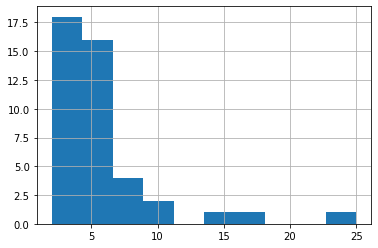

In [5]:
feat_categorical_nunique.hist();

In [6]:
# categorical features to one-hot-encode
feat_categorical_nunique = X.select_dtypes(include='object').nunique()
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)

### Check missing values

**Select strategy for columns with missing values according to the data description in Kaggle:**
- `alley` -> NA is no Alley -> set value to "None"
- `LotFrontage` -> NaN in theory not possible? -> impute (number)
- `MasVnrType` -> None is correct -> set value to "None"
- MasVnrArea -> impute missing numbers
- `BsmtCond`', '`BsmtExposure`', '`BsmtFinType1`', '`BsmtFinType2`' -> no basement -> set value to "None"
- `Electrical`-> NaN in theory not possible? -> impute  (categorical)
- `FireplaceQu` -> no fireplace -> set value to "None"
- '`GarageType`', '`GarageFinish`', '`GarageQual`', '`GarageCond`' -> NAN is no garage -> set value to "None"
- `GarageYrBlt` -> NAN is no garage -> set value to 0
- `PoolQC` -> Na is no pool -> set value to "None"
- `Fence` -> NA is no fence -> set value to "None"
- `MiscFeature` -> Na is no special feature -> set value to "None"

In [7]:
# Imputer for categorical columns with NaN
imputer_none = SimpleImputer(strategy="constant", fill_value="None")

# Imputer Electrical
imputer_electrical = SimpleImputer(strategy="most_frequent")

# Imputer LotFrontage
imputer_lotfrontage = SimpleImputer() #strategy (median or mean will be determined in GridSearch)

# Imputer GarageYrBlt
imputer_garage = SimpleImputer(strategy="constant", fill_value=0)

## Pipeline

### Baseline

In [8]:
df_train.columns[df_train.isna().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [9]:
hasgarage_constructor =FunctionTransformer(lambda df: pd.DataFrame(df["GarageYrBlt"].notna()))

In [10]:
num_col = make_column_selector(dtype_include=np.number)

imp_num = make_column_transformer(
    (imputer_lotfrontage, ["LotFrontage", "MasVnrArea"]),
    (imputer_garage, ["GarageYrBlt"]),
    (SimpleImputer(),num_col),
    remainder="passthrough"
    )

preproc_num = make_pipeline(
    imp_num,
    StandardScaler()
    )

In [11]:
# Select categorical columns for replacing Nan with "None"
columns_none = ["Alley", "MasVnrType", "BsmtCond", 'BsmtExposure', 'BsmtFinType1',"BsmtQual", 
                'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                'GarageQual', 'GarageCond', "PoolQC", "Fence", "MiscFeature"]

cat_col = make_column_selector(dtype_include=object)

imp_cat = make_column_transformer(
    (imputer_electrical, ["Electrical"]),
    (imputer_none, cat_col),
    remainder="passthrough"
    )

preproc_cat = make_pipeline(
    imp_cat,
    OneHotEncoder(handle_unknown="ignore")
    )

In [12]:
preproc_baseline = make_column_transformer(
    (preproc_num, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_cat, feat_categorical_small),
    remainder="drop")

In [13]:
union = FeatureUnion([
    ('preprocess', preproc_baseline), 
    ('Has_Garage', hasgarage_constructor)
])
union

FeatureUnion(transformer_list=[('preprocess',
                                ColumnTransformer(transformers=[('pipeline-1',
                                                                 Pipeline(steps=[('columntransformer',
                                                                                  ColumnTransformer(remainder='passthrough',
                                                                                                    transformers=[('simpleimputer-1',
                                                                                                                   SimpleImputer(),
                                                                                                                   ['LotFrontage',
                                                                                                                    'MasVnrArea']),
                                                                                                                  ('simpleimputer-2',
                                                                                                                   SimpleImputer(fill_value=0,
                                                                                                                                 strategy='constant'),
                                                                                                                   ['GarageYrBlt']),
                                                                                                                  ('simpleimputer-3...
                                                                  'RoofStyle',
                                                                  'MasVnrType',
                                                                  'ExterQual',
                                                                  'ExterCond',
                                                                  'Foundation',
                                                                  'BsmtQual',
                                                                  'BsmtCond',
                                                                  'BsmtExposure',
                                                                  'BsmtFinType1',
                                                                  'BsmtFinType2',
                                                                  'Heating',
                                                                  'HeatingQC',
                                                                  'CentralAir',
                                                                  'Electrical',
                                                                  'KitchenQual',
                                                                  'FireplaceQu',
                                                                  'GarageType',
                                                                  'GarageFinish',
                                                                  'GarageQual',
                                                                  'GarageCond',
                                                                  'PavedDrive', ...])])),
                               ('Has_Garage',
                                FunctionTransformer(func=<function <lambda> at 0x12700c280>))])

In [14]:
pipe = make_pipeline(
    union,
    Ridge()
)

In [15]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

# Equivalent formulation
rmsle_neg = make_scorer(
    lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
    greater_is_better=False
)

In [16]:
cross_val_score(pipe, X, y, cv=5, scoring=rmsle).mean()

0.1740381777738535

In [17]:
X_test = pd.read_csv("../data/kaggle/HousePrices/test.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])#.reset_index()

In [18]:
# Predict y_pred_baseline
pipe.fit(X,y)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('preprocess',
                                                 ColumnTransformer(transformers=[('pipeline-1',
                                                                                  Pipeline(steps=[('columntransformer',
                                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                                     transformers=[('simpleimputer-1',
                                                                                                                                    SimpleImputer(),
                                                                                                                                    ['LotFrontage',
                                                                                                                                     'MasVnrArea']),
                                                                                                                                   ('simpleimputer-2',
                                                                                                                                    SimpleImputer(fill_value=0,
                                                                                                                                                  strategy='constant'),
                                                                                                                                    ['...
                                                                                   'ExterQual',
                                                                                   'ExterCond',
                                                                                   'Foundation',
                                                                                   'BsmtQual',
                                                                                   'BsmtCond',
                                                                                   'BsmtExposure',
                                                                                   'BsmtFinType1',
                                                                                   'BsmtFinType2',
                                                                                   'Heating',
                                                                                   'HeatingQC',
                                                                                   'CentralAir',
                                                                                   'Electrical',
                                                                                   'KitchenQual',
                                                                                   'FireplaceQu',
                                                                                   'GarageType',
                                                                                   'GarageFinish',
                                                                                   'GarageQual',
                                                                                   'GarageCond',
                                                                                   'PavedDrive', ...])])),
                                                ('Has_Garage',
                                                 FunctionTransformer(func=<function <lambda> at 0x12700c280>))])),
                ('ridge', Ridge())])

In [19]:
y_pred_baseline = pipe.predict(X_test)
y_pred_baseline

array([112179.25017197, 140519.61554546, 176136.58129578, ...,
       158051.24331339, 121294.51905589, 238211.44373603])

### Ridge + GridSearch

In [66]:
estimator = Ridge()

pipe_adv = make_pipeline(
    union,
    estimator
)

In [67]:
pipe_adv

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('preprocess',
                                                 ColumnTransformer(transformers=[('pipeline-1',
                                                                                  Pipeline(steps=[('columntransformer',
                                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                                     transformers=[('simpleimputer-1',
                                                                                                                                    SimpleImputer(),
                                                                                                                                    ['LotFrontage',
                                                                                                                                     'MasVnrArea']),
                                                                                                                                   ('simpleimputer-2',
                                                                                                                                    SimpleImputer(fill_value=0,
                                                                                                                                                  strategy='constant'),
                                                                                                                                    ['...
                                                                                   'ExterQual',
                                                                                   'ExterCond',
                                                                                   'Foundation',
                                                                                   'BsmtQual',
                                                                                   'BsmtCond',
                                                                                   'BsmtExposure',
                                                                                   'BsmtFinType1',
                                                                                   'BsmtFinType2',
                                                                                   'Heating',
                                                                                   'HeatingQC',
                                                                                   'CentralAir',
                                                                                   'Electrical',
                                                                                   'KitchenQual',
                                                                                   'FireplaceQu',
                                                                                   'GarageType',
                                                                                   'GarageFinish',
                                                                                   'GarageQual',
                                                                                   'GarageCond',
                                                                                   'PavedDrive', ...])])),
                                                ('Has_Garage',
                                                 FunctionTransformer(func=<function <lambda> at 0x12700c280>))])),
                ('ridge', Ridge())])

In [68]:
pipe_adv.get_params()

{'memory': None,
 'steps': [('featureunion',
   FeatureUnion(transformer_list=[('preprocess',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('columntransformer',
                                                                                     ColumnTransformer(remainder='passthrough',
                                                                                                       transformers=[('simpleimputer-1',
                                                                                                                      SimpleImputer(),
                                                                                                                      ['LotFrontage',
                                                                                                                       'MasVnrArea']),
                                                 

In [69]:
param_grid = {
    "ridge__alpha": [1.0,10.0,50.0,100.0,200.0,400.0,500.0,600.0,700.0,1000.0],
    "ridge__solver": ['auto','svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [70]:
grid_cv = GridSearchCV(pipe_adv, param_grid, scoring=rmsle_neg, cv=10, n_jobs=-1)

In [71]:
grid_cv.fit(X,y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('featureunion',
                                        FeatureUnion(transformer_list=[('preprocess',
                                                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                                                         Pipeline(steps=[('columntransformer',
                                                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                                                            transformers=[('simpleimputer-1',
                                                                                                                                                           SimpleImputer(),
                                                                                                                                                           ['LotFrontage',
                                                                                                                                                            'MasVnrArea']),
                                                                                                                                                          ('simpleimputer-2',
                                                                                                                                                           SimpleImputer(fill_va...
                                                                                                          'GarageCond',
                                                                                                          'PavedDrive', ...])])),
                                                                       ('Has_Garage',
                                                                        FunctionTransformer(func=<function <lambda> at 0x12700c280>))])),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [1.0, 10.0, 50.0, 100.0, 200.0, 400.0,
                                          500.0, 600.0, 700.0, 1000.0],
                         'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                           'sparse_cg', 'sag', 'saga']},
             scoring=make_scorer(<lambda>, greater_is_better=False))

In [74]:
grid_cv.cv_results_["mean_test_score"].mean()

-0.15303419023162226

In [75]:
y_pred = grid_cv.predict(X_test)

## Lasso + Grid

In [109]:
estimator = Lasso()

pipe_adv = make_pipeline(
    union_test,
    estimator
)

In [110]:
param_grid = {
    "lasso__alpha": [1.0,10.0,50.0,100.0,200.0,400.0,500.0,600.0,700.0,1000.0],
    #"lasso__selection": ['cyclic', 'random']
}

In [113]:
grid_cv = GridSearchCV(pipe_adv, param_grid, scoring=rmsle_neg, cv=10, n_jobs=-1)

In [114]:
grid_cv.fit(X,y)

/Users/philippheitmann/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e+10, tolerance: 8.205e+08
  model = cd_fast.enet_coordinate_descent(
/Users/philippheitmann/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.910e+10, tolerance: 8.448e+08
  model = cd_fast.enet_coordinate_descent(
/Users/philippheitmann/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

/Users/philippheitmann/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan 0.1764198  0.15315966        nan        nan        nan
        nan        nan        nan        nan]
  warnings.warn(
/Users/philippheitmann/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.183e+09, tolerance: 9.208e+08
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('featureunion',
                                        FeatureUnion(transformer_list=[('preprocess',
                                                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                                                         Pipeline(steps=[('knnimputer',
                                                                                                                          KNNImputer()),
                                                                                                                         ('minmaxscaler',
                                                                                                                          MinMaxScaler())]),
                                                                                                         ['1stFlrSF',
                                                                                                          '2ndFlrSF',
                                                                                                          '3SsnPorch',
                                                                                                          'BedroomAbvGr',
                                                                                                          'BsmtFinSF1',
                                                                                                          'BsmtFinSF2',
                                                                                                          'BsmtFullBath',
                                                                                                          'BsmtHalfBath',
                                                                                                          'BsmtUnfSF',
                                                                                                          'E...
                                                                                                          'MSZoning',
                                                                                                          'MasVnrType',
                                                                                                          'MiscFeature',
                                                                                                          'Neighborhood',
                                                                                                          'RoofMatl',
                                                                                                          'RoofStyle',
                                                                                                          'SaleCondition',
                                                                                                          'SaleType',
                                                                                                          'Street',
                                                                                                          'Utilities'])])),
                                                                       ('Has_Garage',
                                                                        FunctionTransformer(func=<function <lambda> at 0x12700c280>))])),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [1.0, 10.0, 50.0, 100.0, 200.0, 400.0,
                                          500.0, 600.0, 700.0, 1000.0]},
             scoring=make_scorer(<lambda>))

In [108]:
grid_cv.best_params_

{'lasso__alpha': 50.0, 'lasso__selection': 'random'}

In [105]:
grid_cv.cv_results_["mean_test_score"].mean()

nan

In [106]:
y_pred = grid_cv.predict(X_test)

In [107]:
y_pred

array([110419.39166157, 164488.19419236, 174074.00532109, ...,
       157960.4965768 , 110819.30687602, 223024.23809931])

## Elasticnet + grid

In [83]:
estimator = ElasticNet()

pipe_adv = make_pipeline(
    union,
    estimator
)

In [87]:
param_grid = {
    "elasticnet__alpha": [1.0,10.0,50.0,100.0,200.0,400.0,500.0,600.0,700.0,1000.0],
    "elasticnet__l1_ratio": np.linspace(0.1,0.9,9),
    "elasticnet__selection": ['cyclic', 'random']
}

In [88]:
grid_cv = GridSearchCV(pipe_adv, param_grid, scoring=rmsle_neg, cv=10, n_jobs=-1)

In [89]:
grid_cv.fit(X,y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('featureunion',
                                        FeatureUnion(transformer_list=[('preprocess',
                                                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                                                         Pipeline(steps=[('columntransformer',
                                                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                                                            transformers=[('simpleimputer-1',
                                                                                                                                                           SimpleImputer(),
                                                                                                                                                           ['LotFrontage',
                                                                                                                                                            'MasVnrArea']),
                                                                                                                                                          ('simpleimputer-2',
                                                                                                                                                           SimpleImputer(fill_va...
                                                                        FunctionTransformer(func=<function <lambda> at 0x12700c280>))])),
                                       ('elasticnet', ElasticNet())]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': [1.0, 10.0, 50.0, 100.0, 200.0,
                                               400.0, 500.0, 600.0, 700.0,
                                               1000.0],
                         'elasticnet__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'elasticnet__selection': ['cyclic', 'random']},
             scoring=make_scorer(<lambda>, greater_is_better=False))

In [90]:
grid_cv.cv_results_["mean_test_score"].mean()

-0.33339957815800375

In [91]:
y_pred = grid_cv.predict(X_test)

In [92]:
grid_cv.best_params_

{'elasticnet__alpha': 1.0,
 'elasticnet__l1_ratio': 0.7000000000000001,
 'elasticnet__selection': 'random'}

## Sumbmission

In [115]:
results = pd.concat([X_test_ids, pd.Series(y_pred, name="SalePrice")], axis=1)

In [116]:
# Export to Kaggle format submission in the `data` folder
results.to_csv("submission_lasso_test.csv", header=True, index=False)

In [95]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [96]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [97]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [98]:
preproc_test = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_test


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [99]:
union_test = FeatureUnion([
    ('preprocess', preproc_test), 
    ('Has_Garage', hasgarage_constructor)
])
union_test

FeatureUnion(transformer_list=[('preprocess',
                                ColumnTransformer(transformers=[('pipeline-1',
                                                                 Pipeline(steps=[('knnimputer',
                                                                                  KNNImputer()),
                                                                                 ('minmaxscaler',
                                                                                  MinMaxScaler())]),
                                                                 ['1stFlrSF',
                                                                  '2ndFlrSF',
                                                                  '3SsnPorch',
                                                                  'BedroomAbvGr',
                                                                  'BsmtFinSF1',
                                                                  'BsmtFinSF2',
                                                                  'BsmtFullBath',
                                                                  'BsmtHalfBath',
                                                                  'BsmtUnfSF',
                                                                  'EnclosedPorch',
                                                                  'Fireplaces',
                                                                  'FullBath',
                                                                  'GarageArea',
                                                                  'GarageCar...
                                                                 ['Alley',
                                                                  'BldgType',
                                                                  'CentralAir',
                                                                  'Condition1',
                                                                  'Condition2',
                                                                  'Exterior1st',
                                                                  'Exterior2nd',
                                                                  'Foundation',
                                                                  'GarageType',
                                                                  'Heating',
                                                                  'HouseStyle',
                                                                  'LotConfig',
                                                                  'MSZoning',
                                                                  'MasVnrType',
                                                                  'MiscFeature',
                                                                  'Neighborhood',
                                                                  'RoofMatl',
                                                                  'RoofStyle',
                                                                  'SaleCondition',
                                                                  'SaleType',
                                                                  'Street',
                                                                  'Utilities'])])),
                               ('Has_Garage',
                                FunctionTransformer(func=<function <lambda> at 0x12700c280>))])